# **Image Classification with ConvNeXt**

Written By: Tharnarch Thoranisttakul

This project is for the internship program in Japan at Kanazawa University.

The topic is as stated above. Firstly, we will take a look at classifying image with ConvNeXt. Then, we will take a look at classifying image with Transformers (if we have time then we will take a look at Transformers).

Right now, we will only focus on **ConvNeXt**.

## **Data Exploration**

The task from this lab was to use **CIFAR-100** as the dataset for image classificatoin

In [26]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from typing import List
from tqdm.notebook import tqdm
from PIL import Image
import glob
import os

%matplotlib inline

# Import scikit-learn libraries and packages
from sklearn.preprocessing import LabelEncoder

# Import PyTorch libraries and packages
import torch
import torch.nn as nn
from torch import Tensor
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, random_split, TensorDataset, Dataset
import torchvision
from torchvision import transforms
from torchvision.models import resnet50, ConvNeXt, ConvNeXt_Base_Weights
from torchvision.ops import StochasticDepth

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [27]:
# Extract dataset
# Uncomment the code below to extract the dataset
# !tar xvzf data/cifar-100-python.tar.gz -C data

In [28]:
def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

In [29]:
# Load the data
train = unpickle('data/cifar-100-python/train')
test = unpickle('data/cifar-100-python/test')

In [30]:
print(f'Train Keys: {train.keys()}\nTest Keys: {test.keys()}')
print('-'*20)
print(f'Train Data Shape: {train[b"data"].shape}\nTest Data Shape: {test[b"data"].shape}')
print('-'*20)
print(f'Train Data Type: {type(train[b"data"])}\nTest Data Type: {type(test[b"data"])}')

Train Keys: dict_keys([b'filenames', b'batch_label', b'fine_labels', b'coarse_labels', b'data'])
Test Keys: dict_keys([b'filenames', b'batch_label', b'fine_labels', b'coarse_labels', b'data'])
--------------------
Train Data Shape: (50000, 3072)
Test Data Shape: (10000, 3072)
--------------------
Train Data Type: <class 'numpy.ndarray'>
Test Data Type: <class 'numpy.ndarray'>


### **Dataset Description**

From the [official website](https://www.cs.toronto.edu/~kriz/cifar.html), the CIFAR-100 dataset contains 100 classes. Each class contains 600 images each, 500 of which are training images and the rest are testing images.

Similarly to CIFAR-10, the data shape is a 60000x3072 numpy array. This corresponds to the code and description above, which is 500 training images and 100 testing images in each class, resulting in a grand total of 50000x3072 and 10000x3072 numpy array.

In [31]:
print(f'Train Coarse Labels: {train[b"coarse_labels"]}\nTest Coarse Labels: {test[b"coarse_labels"]}')
print('-'*20)
print(f'Train Fine Labels: {train[b"fine_labels"]}\nTest Fine Labels: {test[b"fine_labels"]}')
print('-'*20)
print(f'Train Batch Label: {train[b"batch_label"]}\nTest Batch Label: {test[b"batch_label"]}')

Train Coarse Labels: [11, 15, 4, 14, 1, 5, 18, 3, 10, 11, 5, 17, 2, 9, 10, 5, 18, 8, 16, 10, 16, 17, 2, 5, 17, 6, 12, 17, 8, 12, 18, 9, 17, 16, 11, 5, 19, 14, 7, 6, 15, 13, 10, 8, 17, 9, 14, 18, 19, 15, 1, 7, 5, 3, 10, 7, 17, 6, 14, 17, 16, 0, 0, 8, 4, 14, 4, 10, 15, 4, 2, 16, 11, 19, 16, 7, 19, 14, 10, 8, 5, 12, 12, 11, 10, 8, 12, 13, 10, 7, 14, 11, 14, 19, 0, 4, 12, 13, 1, 15, 0, 5, 0, 8, 3, 15, 4, 19, 17, 6, 17, 12, 6, 0, 14, 10, 9, 11, 6, 10, 12, 1, 14, 4, 8, 1, 2, 12, 4, 12, 18, 17, 5, 0, 6, 0, 12, 11, 9, 5, 17, 2, 14, 12, 5, 0, 13, 12, 16, 4, 13, 0, 18, 15, 10, 15, 5, 13, 1, 14, 12, 3, 19, 1, 2, 15, 5, 2, 3, 12, 16, 0, 11, 12, 2, 0, 4, 15, 7, 9, 11, 14, 11, 3, 13, 13, 19, 13, 14, 8, 14, 1, 16, 9, 16, 18, 19, 6, 5, 19, 5, 1, 14, 14, 10, 12, 8, 7, 10, 9, 16, 19, 9, 13, 16, 11, 13, 9, 5, 18, 3, 2, 5, 5, 11, 2, 5, 3, 14, 19, 18, 18, 13, 12, 19, 11, 13, 5, 15, 5, 18, 6, 14, 11, 3, 17, 2, 16, 5, 5, 8, 18, 18, 4, 14, 10, 10, 19, 17, 14, 14, 0, 8, 5, 12, 12, 7, 14, 12, 17, 4, 1, 15, 14, 

The fine labels are classes, while the coarse labels are superclasses stated below.

|**Superclass No.**|**Superclass**|**Classes**|
|:-:|:-:|:-:|
|1|aquatic mammals|beaver, dolphin, otter, seal, whale|
|2|fish|aquarium fish, flatfish, ray, shark, trout|
|3|flowers|orchids, poppies, roses, sunflowers, tulips|
|4|food containers|bottles, bowls, cans, cups, plates|
|5|fruit and vegetables|apples, mushrooms, oranges, pears, sweet peppers|
|6|household electrical devices|clock, computer keyboard, lamp, telephone, television|
|7|household furniture|bed, chair, couch, table, wardrobe|
|8|insects|bee, beetle, butterfly, caterpillar, cockroach|
|9|large carnivores|bear, leopard, lion, tiger, wolf|
|10|large man-made outdoor things|bridge, castle, house, road, skyscraper|
|11|large natural outdoor scenes|cloud, forest, mountain, plain, sea|
|12|large omnivores and herbivores|camel, cattle, chimpanzee, elephant, kangaroo|
|13|medium-sized mammals|fox, porcupine, possum, raccoon, skunk|
|14|non-insect invertebrates|crab, lobster, snail, spider, worm|
|15|people|baby, boy, girl, man, woman|
|16|reptiles|crocodile, dinosaur, lizard, snake, turtle|
|17|small mammals|hamster, mouse, rabbit, shrew, squirrel|
|18|trees|maple, oak, palm, pine, willow|
|19|vehicles 1|bicycle, bus, motorcycle, pickup truck, train|
|20|vehicles 2|lawn-mower, rocket, streetcar, tank, tractor|

The labels are kept in the meta file. Therefore, we will extract the label names (fine and coarse) from the meta file directly.

In [32]:
# Load the labels
label = unpickle('data/cifar-100-python/meta')
print(f'Label Keys: {label.keys()}')
print('-'*20)
print(f'Label Fine Label Names: {label[b"fine_label_names"]}')
print('-'*20)
print(f'Label Coarse Label Names: {label[b"coarse_label_names"]}')

label_fine = label[b"fine_label_names"]
label_coarse = label[b"coarse_label_names"]

# Decode labels
label_fine = [x.decode('utf-8') for x in label_fine]
label_coarse = [x.decode('utf-8') for x in label_coarse]

label2id = {label_fine[i]: i for i in range(len(label_fine))}
id2label = {i: label_fine[i] for i in range(len(label_fine))}

Label Keys: dict_keys([b'fine_label_names', b'coarse_label_names'])
--------------------
Label Fine Label Names: [b'apple', b'aquarium_fish', b'baby', b'bear', b'beaver', b'bed', b'bee', b'beetle', b'bicycle', b'bottle', b'bowl', b'boy', b'bridge', b'bus', b'butterfly', b'camel', b'can', b'castle', b'caterpillar', b'cattle', b'chair', b'chimpanzee', b'clock', b'cloud', b'cockroach', b'couch', b'crab', b'crocodile', b'cup', b'dinosaur', b'dolphin', b'elephant', b'flatfish', b'forest', b'fox', b'girl', b'hamster', b'house', b'kangaroo', b'keyboard', b'lamp', b'lawn_mower', b'leopard', b'lion', b'lizard', b'lobster', b'man', b'maple_tree', b'motorcycle', b'mountain', b'mouse', b'mushroom', b'oak_tree', b'orange', b'orchid', b'otter', b'palm_tree', b'pear', b'pickup_truck', b'pine_tree', b'plain', b'plate', b'poppy', b'porcupine', b'possum', b'rabbit', b'raccoon', b'ray', b'road', b'rocket', b'rose', b'sea', b'seal', b'shark', b'shrew', b'skunk', b'skyscraper', b'snail', b'snake', b'spider

In [33]:
train_data = train[b"data"]
train_coarse_labels = train[b"coarse_labels"]
train_fine_labels = train[b"fine_labels"]
train_batch_label = train[b"batch_label"]

test_data = test[b"data"]
test_coarse_labels = test[b"coarse_labels"]
test_fine_labels = test[b"fine_labels"]
test_batch_label = test[b"batch_label"]

In [34]:
train_data[0], train_coarse_labels[0], train_fine_labels[0], train_batch_label, test_data[0], test_coarse_labels[0], test_fine_labels[0], test_batch_label

(array([255, 255, 255, ...,  10,  59,  79], dtype=uint8),
 11,
 19,
 b'training batch 1 of 1',
 array([199, 196, 195, ..., 215, 211, 183], dtype=uint8),
 10,
 49,
 b'testing batch 1 of 1')

In [35]:
print(f'Train data min: {train_data.min()}\nTrain data max: {train_data.max()}')
print(f'Test data min: {test_data.min()}\nTest data max: {test_data.max()}')
print('-'*20)
print(f'Train data mean: {train_data.mean()}\nTrain data std: {train_data.std()}')
print(f'Test data mean: {test_data.mean()}\nTest data std: {test_data.std()}')

Train data min: 0
Train data max: 255
Test data min: 0
Test data max: 255
--------------------
Train data mean: 121.936059453125
Train data std: 68.38895658894971
Test data mean: 122.24118916015625
Test data std: 68.63056877656638


## **Data Preprocessing**

Since the image data's range is (0, 255), we will normalize it to (0, 1).

In [36]:
# Reshape the data
train_data = train_data.reshape(50000, 32, 32, 3)
test_data = test_data.reshape(10000, 32, 32, 3)

print(f'Train Data Shape: {train_data.shape}\nTest Data Shape: {test_data.shape}')

Train Data Shape: (50000, 32, 32, 3)
Test Data Shape: (10000, 32, 32, 3)


In [37]:
# Normalize the data
train_data, test_data = train_data/255.0, test_data/255.0

In [38]:
def plot_images(data, datalabel, fulllabel):
    plt.figure(figsize=(10, 10))
    for i in range(25):
        plt.subplot(5, 5, i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(data[i])
        plt.xlabel(fulllabel[datalabel[i]])

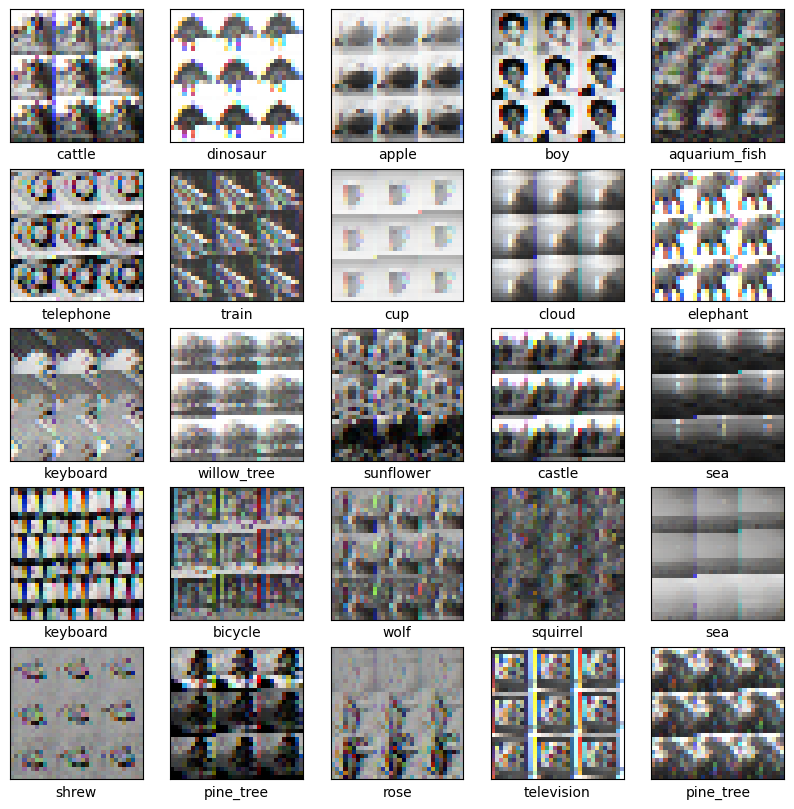

In [39]:
plot_images(train_data, train_fine_labels, label_fine)

Seems like we reshaped the data wrongly. We will try to reshape it again by separating each color profile (R, G, B) and restack them.

In [40]:
train_data = train[b'data']
test_data = test[b'data']

train_data_R = train_data[:, :1024].reshape(50000, 32, 32)
train_data_G = train_data[:, 1024:2048].reshape(50000, 32, 32)
train_data_B = train_data[:, 2048:].reshape(50000, 32, 32)

test_data_R = test_data[:, :1024].reshape(10000, 32, 32)
test_data_G = test_data[:, 1024:2048].reshape(10000, 32, 32)
test_data_B = test_data[:, 2048:].reshape(10000, 32, 32)

# Stack the data
train_data = np.stack((train_data_R, train_data_G, train_data_B), axis=3)
test_data = np.stack((test_data_R, test_data_G, test_data_B), axis=3)

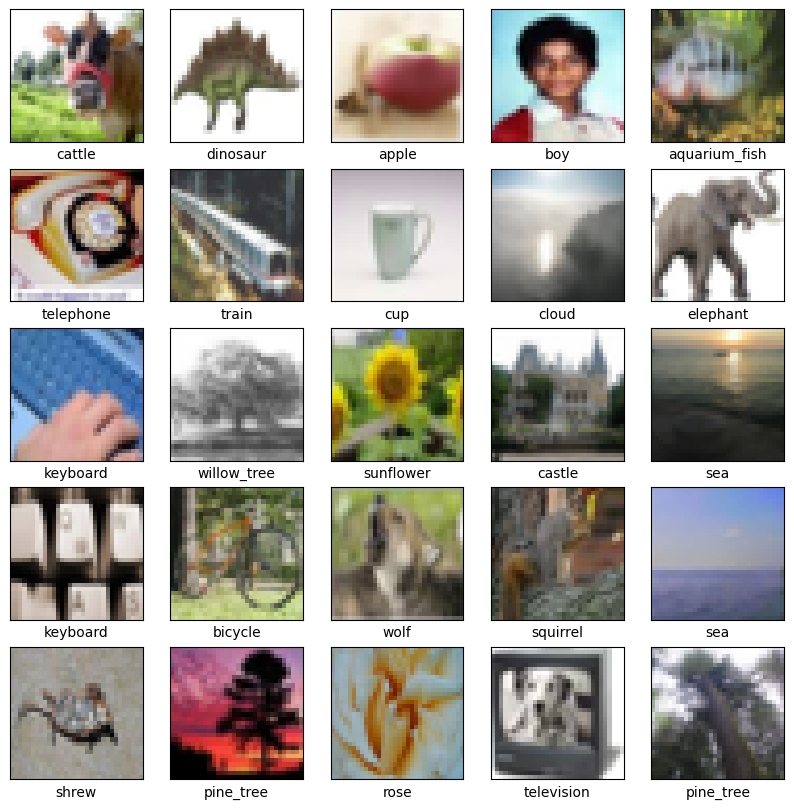

In [41]:
plot_images(train_data, train_fine_labels, label_fine)

In [42]:
print(f'Train Data Shape: {train_data.shape}\nTest Data Shape: {test_data.shape}')

Train Data Shape: (50000, 32, 32, 3)
Test Data Shape: (10000, 32, 32, 3)


The reason why we have to separate them like this instead of directly reshaping them is because the data were flatten before saving as text file.

Credit to: https://www.kaggle.com/code/yipengzhou3/cifar100-pytorch for doing the same 'wrong' approach to reshaping the data.

In [43]:
X_train, y_train = train_data, train_fine_labels
X_test, y_test = test_data, test_fine_labels

num_classes = 100
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

In [44]:
#Transform data to Tensor
transform_data = transforms.Compose([transforms.ToTensor()])

In [45]:
# Apply the augmentation
noaugment_train_data = []
noaugment_train_label = []
for image, label in zip(X_train, y_train_encoded):
    noaugment_train_data.append(transform_data(image))
    noaugment_train_label.append(label)

noaugment_test_data = []
noaugment_test_label = []
for image, label in zip(X_test, y_test_encoded):
    noaugment_test_data.append(transform_data(image))
    noaugment_test_label.append(label)

noaugment_train_data = torch.stack(noaugment_train_data)
noaugment_test_data = torch.stack(noaugment_test_data)

print(f'Augmented Train Data Shape: {noaugment_train_data.shape}\nAugmented Test Data Shape: {noaugment_test_data.shape}')

Augmented Train Data Shape: torch.Size([50000, 3, 32, 32])
Augmented Test Data Shape: torch.Size([10000, 3, 32, 32])


In [46]:
# Create the dataset
train_dataset = TensorDataset(noaugment_train_data, torch.Tensor(noaugment_train_label))
test_dataset = TensorDataset(noaugment_test_data, torch.Tensor(noaugment_test_label))

# Create the dataloader
train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=256, shuffle=False)

In [47]:
from transformers.modeling_outputs import ImageClassifierOutputWithNoAttention
# Training
def train_model(models, modelnames, criterion, optimizer, scheduler, num_epochs, train_loader, test_loader):

    # Store the loss and accuracy
    traintestData = {}

    ### Train the model ###
    for model, modelname in zip(models, modelnames):
        train_loss = []
        train_acc = []
        test_acc = []
        for epoch in range(num_epochs):
            model.train()
            running_loss = 0.0
            total_correct = 0
            total_samples = 0
            for _, batch in enumerate(train_loader):
                images = batch[0].to(device)
                labels = batch[1].to(device).long()

                optimizer.zero_grad()
                
                outputs = model(images)

                # Convert outputs to tensor
                if isinstance(outputs, ImageClassifierOutputWithNoAttention):
                    outputs = outputs.logits

                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()

                running_loss += loss.item() * images.size(0)

                # Training Accuracy
                _, predicted = torch.max(outputs, dim=1)
                total_correct += (predicted == labels).sum().item()
                total_samples += labels.size(0)

            epoch_loss = running_loss/len(train_loader.dataset)
            accuracy = total_correct/total_samples

            scheduler.step()

            ### Test the model ###

            model.eval()
            num_correct = 0
            total = 0
            with torch.no_grad():
                for _, batch in enumerate(test_loader):
                    images = batch[0].to(device)
                    labels = batch[1].to(device).long()

                    outputs = model(images)

                    if isinstance(outputs, ImageClassifierOutputWithNoAttention):
                        outputs = outputs.logits
                    
                    _, predicted = torch.max(outputs, dim=1)
                    total += labels.size(0)
                    num_correct += (predicted == labels).sum().item()
                    
            # Save the loss and accuracy for train and test set
            train_loss.append(epoch_loss)
            train_acc.append(accuracy)
            test_acc.append(num_correct/total)

            print(f'ConvNeXt {modelname} -> Epoch: {epoch+1}/{num_epochs} | Training Loss: {epoch_loss} | Training Accuracy: {accuracy} | Test Accuracy: {num_correct/total}')

        traintestData[f'Training Loss_{modelname}'] = train_loss
        traintestData[f'Training Accuracy_{modelname}'] = train_acc
        traintestData[f'Test Accuracy_{modelname}'] = test_acc

    return traintestData

In [48]:
def lossAccPlot(lossAccDict, modelnames, cutoff=0):
    names = ['Training Loss', 'Test Accuracy']

    _, axes = plt.subplots(2, 2, figsize=(20, 10))
    for ax, modelname in zip(range(len(axes)), modelnames):
        for i in range(len(names)):
            val = lossAccDict[f'{names[i]}_{modelname}']
            axes[ax][i].plot(val, label=names[i])
            if cutoff != 0:
                # Plot cutoff line
                axes[ax][i].axvline(x=cutoff, color='r', linestyle='--')
            axes[ax][i].set_xlabel('Epoch')
            axes[ax][i].set_ylabel(names[i])
            axes[ax][i].legend()

In [ ]:
def printTestAcc(testAccDict, modelnames):
    # Get last and max test accuracy
    for modelname in modelnames:
        print(f'ConvNeXt {modelname} -> Last Test Accuracy: {testAccDict[f"Test Accuracy_{modelname}"][-1]} | Max Test Accuracy: {max(testAccDict[f"Test Accuracy_{modelname}"])} (Epoch:{testAccDict[f"Test Accuracy_{modelname}"].index(max(testAccDict[f"Test Accuracy_{modelname}"]))})')

## **ConvNeXt**

In [24]:
from transformers import AutoModelForImageClassification

convnext_tiny = AutoModelForImageClassification.from_pretrained("facebook/convnext-tiny-224",
                                                        num_labels=len(label_fine),
                                                        label2id=label2id,
                                                        id2label=id2label,
                                                        ignore_mismatched_sizes=True)

convnext_tiny_wd = AutoModelForImageClassification.from_pretrained("facebook/convnext-tiny-224",
                                                        num_labels=len(label_fine),
                                                        label2id=label2id,
                                                        id2label=id2label,
                                                        ignore_mismatched_sizes=True)

convnext_base = AutoModelForImageClassification.from_pretrained("facebook/convnext-base-224",
                                                        num_labels=len(label_fine),
                                                        label2id=label2id,
                                                        id2label=id2label,
                                                        ignore_mismatched_sizes=True)

convnext_base_wd = AutoModelForImageClassification.from_pretrained("facebook/convnext-base-224",
                                                        num_labels=len(label_fine),
                                                        label2id=label2id,
                                                        id2label=id2label,
                                                        ignore_mismatched_sizes=True)

convnext_tiny.to(device)
convnext_tiny_wd.to(device)
convnext_base.to(device)
convnext_base_wd.to(device)

models = [convnext_tiny, convnext_base]
modelnames = ['Tiny', 'Base']
models_wd = [convnext_tiny_wd, convnext_base_wd]
modelnames_wd = ['TinyWD', 'BaseWD']

Some weights of ConvNextForImageClassification were not initialized from the model checkpoint at facebook/convnext-tiny-224 and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([100, 768]) in the model instantiated
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([100]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of ConvNextForImageClassification were not initialized from the model checkpoint at facebook/convnext-tiny-224 and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([100, 768]) in the model instantiated
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([100]) in the model instantiated
You should probably TRAIN this mo

In [25]:
# Loss function
criterion = nn.CrossEntropyLoss()

# Optimizer
optimizer = torch.optim.AdamW([{'params': model.parameters()} for model in models], lr=5e-5)
optimizer_wd = torch.optim.AdamW([{'params': model.parameters()} for model in models_wd], lr=5e-5, weight_decay=1e-8)

# Learning rate scheduler
lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10)

In [26]:
noWDDict = train_model(models, modelnames, criterion, optimizer, lr_scheduler, num_epochs=30, train_loader=train_loader, test_loader=test_loader)

ConvNeXt Tiny -> Epoch: 1/30 | Loss: 3.7802239363098145 | Test Accuracy: 0.3964
ConvNeXt Tiny -> Epoch: 2/30 | Loss: 2.217087912635803 | Test Accuracy: 0.527
ConvNeXt Tiny -> Epoch: 3/30 | Loss: 1.5592262537384034 | Test Accuracy: 0.59
ConvNeXt Tiny -> Epoch: 4/30 | Loss: 1.2136582033538819 | Test Accuracy: 0.6244
ConvNeXt Tiny -> Epoch: 5/30 | Loss: 0.9919966842269897 | Test Accuracy: 0.6392
ConvNeXt Tiny -> Epoch: 6/30 | Loss: 0.8361852803230285 | Test Accuracy: 0.6462
ConvNeXt Tiny -> Epoch: 7/30 | Loss: 0.7293213107490539 | Test Accuracy: 0.6496
ConvNeXt Tiny -> Epoch: 8/30 | Loss: 0.6600261671066284 | Test Accuracy: 0.6513
ConvNeXt Tiny -> Epoch: 9/30 | Loss: 0.6197333407783508 | Test Accuracy: 0.6514
ConvNeXt Tiny -> Epoch: 10/30 | Loss: 0.6012942883682251 | Test Accuracy: 0.6526
ConvNeXt Tiny -> Epoch: 11/30 | Loss: 0.5964096058273315 | Test Accuracy: 0.6526
ConvNeXt Tiny -> Epoch: 12/30 | Loss: 0.596285811367035 | Test Accuracy: 0.6525
ConvNeXt Tiny -> Epoch: 13/30 | Loss: 0.59

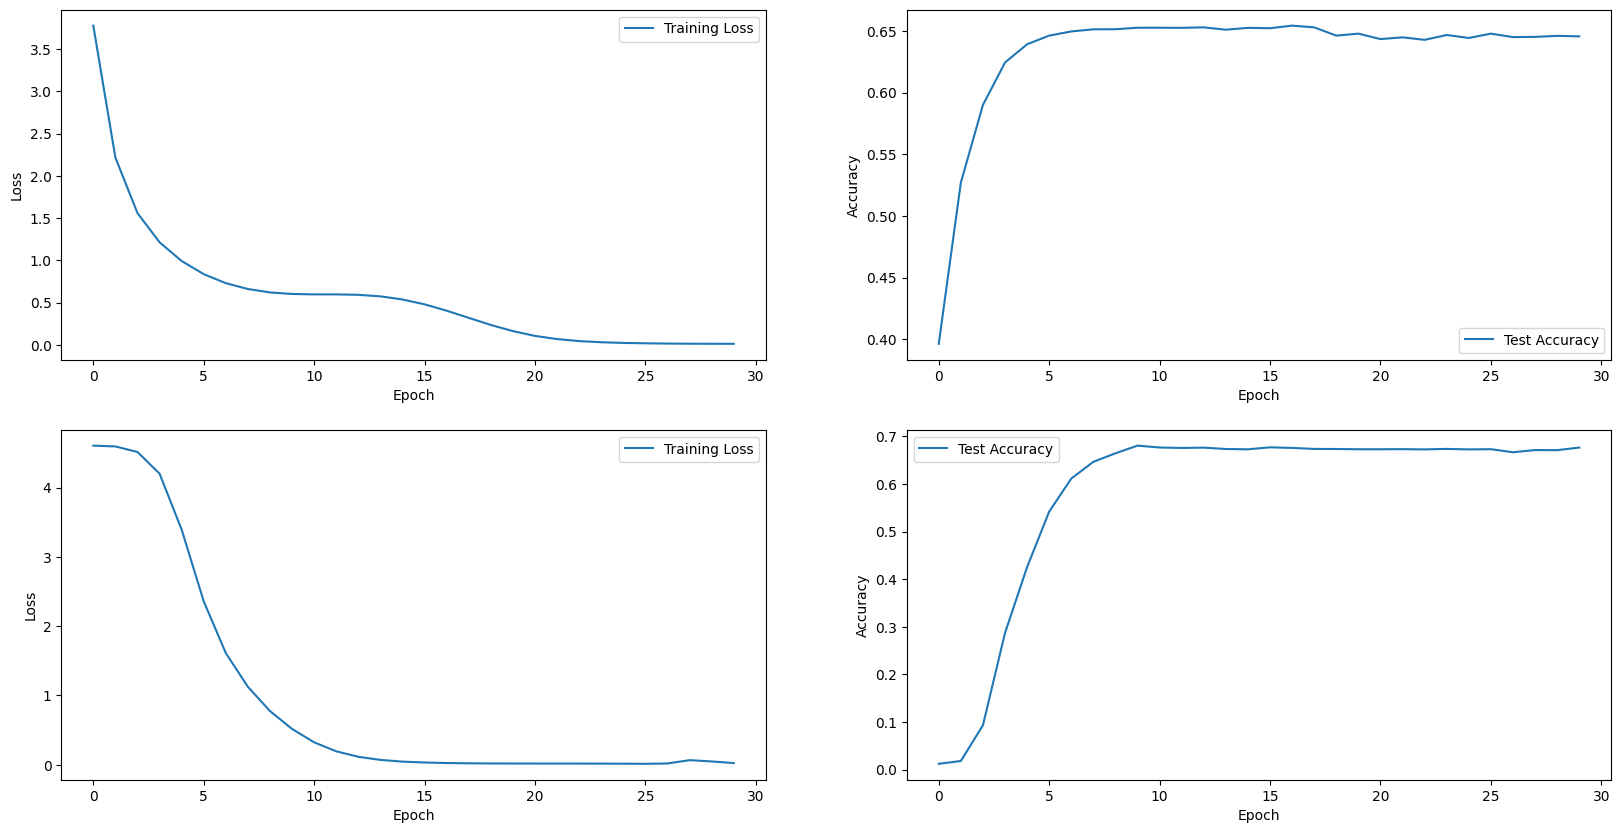

In [27]:
lossAccPlot(noWDDict, modelnames)

In [28]:
WDDict = train_model(models_wd, modelnames_wd, criterion, optimizer_wd, lr_scheduler, num_epochs=30, train_loader=train_loader, test_loader=test_loader)

ConvNeXt TinyWD -> Epoch: 1/30 | Loss: 3.8127765997314453 | Test Accuracy: 0.3992
ConvNeXt TinyWD -> Epoch: 2/30 | Loss: 2.204376941604614 | Test Accuracy: 0.537
ConvNeXt TinyWD -> Epoch: 3/30 | Loss: 1.5180276390075684 | Test Accuracy: 0.5914
ConvNeXt TinyWD -> Epoch: 4/30 | Loss: 1.152325141468048 | Test Accuracy: 0.6237
ConvNeXt TinyWD -> Epoch: 5/30 | Loss: 0.8964569969367981 | Test Accuracy: 0.6426
ConvNeXt TinyWD -> Epoch: 6/30 | Loss: 0.6940325078392029 | Test Accuracy: 0.6517
ConvNeXt TinyWD -> Epoch: 7/30 | Loss: 0.5226919219875336 | Test Accuracy: 0.6555
ConvNeXt TinyWD -> Epoch: 8/30 | Loss: 0.3799620402622223 | Test Accuracy: 0.6607
ConvNeXt TinyWD -> Epoch: 9/30 | Loss: 0.2636096267223358 | Test Accuracy: 0.6529
ConvNeXt TinyWD -> Epoch: 10/30 | Loss: 0.17602789279699327 | Test Accuracy: 0.6556
ConvNeXt TinyWD -> Epoch: 11/30 | Loss: 0.11293589654445649 | Test Accuracy: 0.6508
ConvNeXt TinyWD -> Epoch: 12/30 | Loss: 0.07127474432468414 | Test Accuracy: 0.655
ConvNeXt TinyW

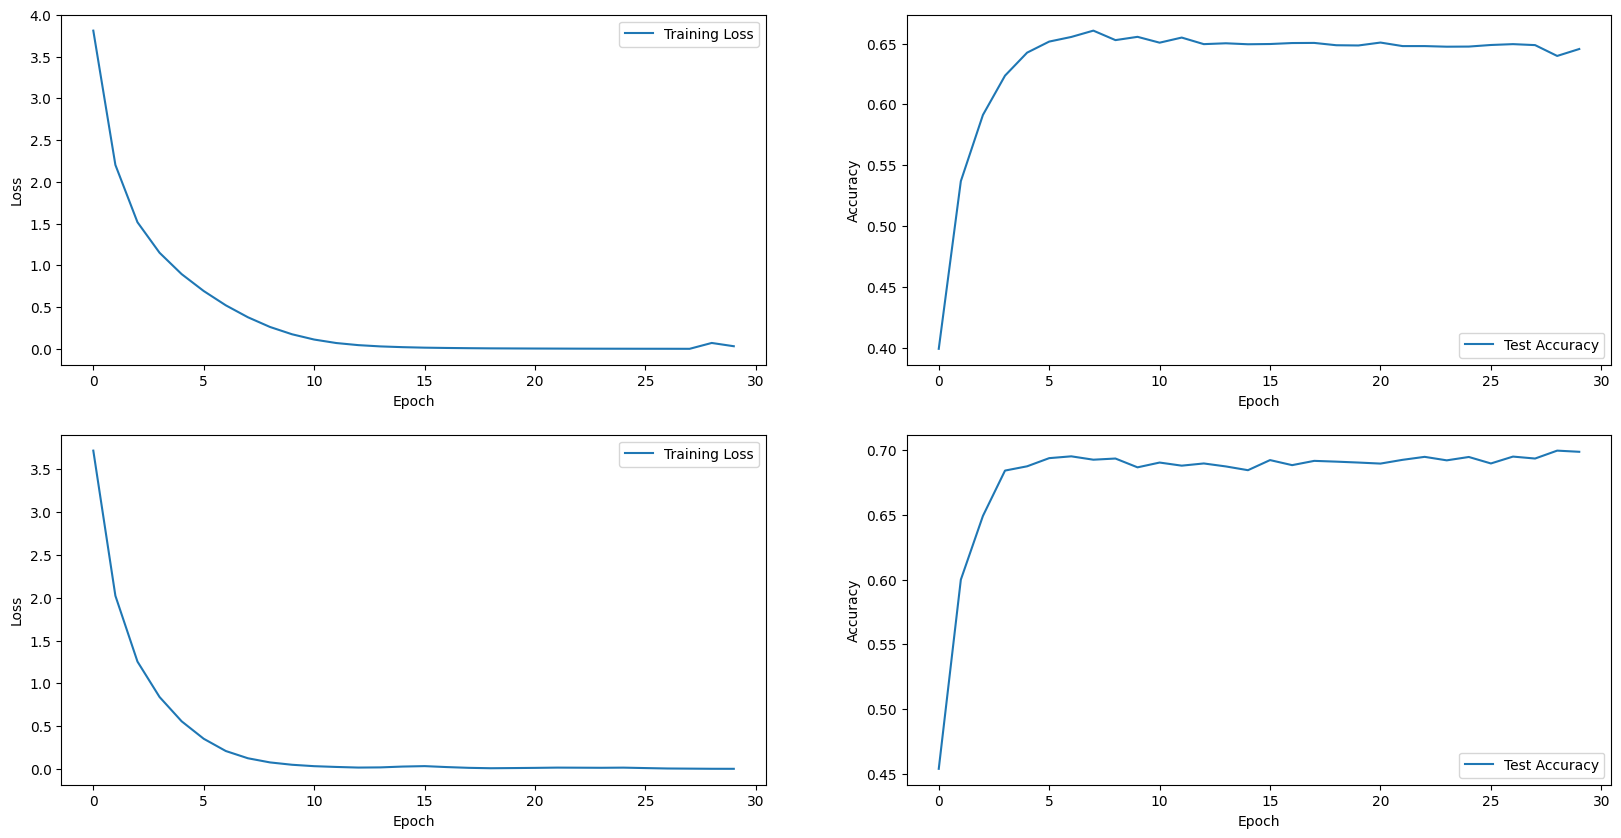

In [29]:
lossAccPlot(WDDict, modelnames_wd)

In [30]:
# Get last and max test accuracy
printTestAcc(noWDDict, modelnames)

print('-'*50)

printTestAcc(WDDict, modelnames_wd)

ConvNeXt Tiny -> Last Test Accuracy: 0.6456 | Max Test Accuracy: 0.6543 (Epoch:16)
ConvNeXt Base -> Last Test Accuracy: 0.6763 | Max Test Accuracy: 0.6804 (Epoch:9)
--------------------------------------------------
ConvNeXt TinyWD -> Last Test Accuracy: 0.6456 | Max Test Accuracy: 0.6607 (Epoch:7)
ConvNeXt BaseWD -> Last Test Accuracy: 0.6987 | Max Test Accuracy: 0.6996 (Epoch:28)


From the result above, applying weight decay to the optimizer improved the performance by 1%. We will come back to visit the preferrable weight decay value and learning rate after we try augmenting the data.

We will stick with using learning rate at 5e-5 and weight decay at 1e-8, which is from the fine-tuning setting section of ConvNeXt's paper.

In [31]:
def save_model(models):
    for model, modelname in zip(models, modelnames):
        torch.save(model.state_dict(), f'models/ConvNeXt_{modelname}.pt')

In [32]:
save_model(models_wd)

del models, models_wd, modelnames, modelnames_wd, noWDDict, WDDict, convnext_tiny, convnext_tiny_wd, convnext_base, convnext_base_wd
torch.cuda.empty_cache()

## **Data Augmentation**

In [49]:
X_train, y_train = train_data, train_fine_labels
X_test, y_test = test_data, test_fine_labels

num_classes = 100
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

In [50]:
#Transform data to Tensor
train_transform = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor()
    ])

test_transform = transforms.Compose([
    transforms.ToTensor()
    ])

In [51]:
# Apply the augmentation
augmented_train_data = []
augmented_train_label = []
for image, label in zip(X_train, y_train_encoded):
    image = Image.fromarray(image)
    augmented_train_data.append(train_transform(image))
    augmented_train_label.append(label)

augmented_test_data = []
augmented_test_label = []
for image, label in zip(X_test, y_test_encoded):
    image = Image.fromarray(image)
    augmented_test_data.append(test_transform(image))
    augmented_test_label.append(label)

augmented_train_data = torch.stack(augmented_train_data)
augmented_test_data = torch.stack(augmented_test_data)

print(f'Augmented Train Data Shape: {augmented_train_data.shape}\nAugmented Test Data Shape: {augmented_test_data.shape}')

Augmented Train Data Shape: torch.Size([50000, 3, 32, 32])
Augmented Test Data Shape: torch.Size([10000, 3, 32, 32])


In [52]:
# Create the dataset
aug_train_dataset = TensorDataset(augmented_train_data, torch.Tensor(augmented_train_label))
aug_test_dataset = TensorDataset(augmented_test_data, torch.Tensor(augmented_test_label))

# Create the dataloader
aug_train_loader = DataLoader(aug_train_dataset, batch_size=256, shuffle=True)
aug_test_loader = DataLoader(aug_test_dataset, batch_size=256, shuffle=False)

In [53]:
convnext_tiny = AutoModelForImageClassification.from_pretrained("facebook/convnext-tiny-224",
                                                        num_labels=len(label_fine),
                                                        label2id=label2id,
                                                        id2label=id2label,
                                                        ignore_mismatched_sizes=True)

convnext_base = AutoModelForImageClassification.from_pretrained("facebook/convnext-base-224",
                                                        num_labels=len(label_fine),
                                                        label2id=label2id,
                                                        id2label=id2label,
                                                        ignore_mismatched_sizes=True)


convnext_tiny.to(device)
convnext_base.to(device)

models = [convnext_tiny, convnext_base]
modelnames = ['Tiny', 'Base']

Some weights of ConvNextForImageClassification were not initialized from the model checkpoint at facebook/convnext-tiny-224 and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([100, 768]) in the model instantiated
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([100]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of ConvNextForImageClassification were not initialized from the model checkpoint at facebook/convnext-base-224 and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([1000, 1024]) in the checkpoint and torch.Size([100, 1024]) in the model instantiated
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([100]) in the model instantiated
You should probably TRAIN this 

In [54]:
# Loss function
criterion = nn.CrossEntropyLoss()

# Optimizer
optimizer = torch.optim.AdamW([{'params': model.parameters()} for model in models], lr=5e-5, weight_decay=1e-8)

# Learning rate scheduler
lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10)

In [55]:
# Train the model
augmentDataModel = train_model(models, modelnames, criterion, optimizer, lr_scheduler, num_epochs=30, train_loader=aug_train_loader, test_loader=aug_test_loader)

ConvNeXt Tiny -> Epoch: 1/30 | Loss: 3.87385436050415 | Test Accuracy: 0.364
ConvNeXt Tiny -> Epoch: 2/30 | Loss: 2.33055893196106 | Test Accuracy: 0.5094
ConvNeXt Tiny -> Epoch: 3/30 | Loss: 1.6642099139404296 | Test Accuracy: 0.5697
ConvNeXt Tiny -> Epoch: 4/30 | Loss: 1.3111782717132567 | Test Accuracy: 0.6022
ConvNeXt Tiny -> Epoch: 5/30 | Loss: 1.0819679291534423 | Test Accuracy: 0.617
ConvNeXt Tiny -> Epoch: 6/30 | Loss: 0.9190927401924134 | Test Accuracy: 0.6239
ConvNeXt Tiny -> Epoch: 7/30 | Loss: 0.8066982992744446 | Test Accuracy: 0.6298
ConvNeXt Tiny -> Epoch: 8/30 | Loss: 0.7328785557174683 | Test Accuracy: 0.6337
ConvNeXt Tiny -> Epoch: 9/30 | Loss: 0.6903292656517028 | Test Accuracy: 0.6313
ConvNeXt Tiny -> Epoch: 10/30 | Loss: 0.6709683393478394 | Test Accuracy: 0.6334
ConvNeXt Tiny -> Epoch: 11/30 | Loss: 0.6658378477668763 | Test Accuracy: 0.6334
ConvNeXt Tiny -> Epoch: 12/30 | Loss: 0.6657386878967285 | Test Accuracy: 0.6328
ConvNeXt Tiny -> Epoch: 13/30 | Loss: 0.660

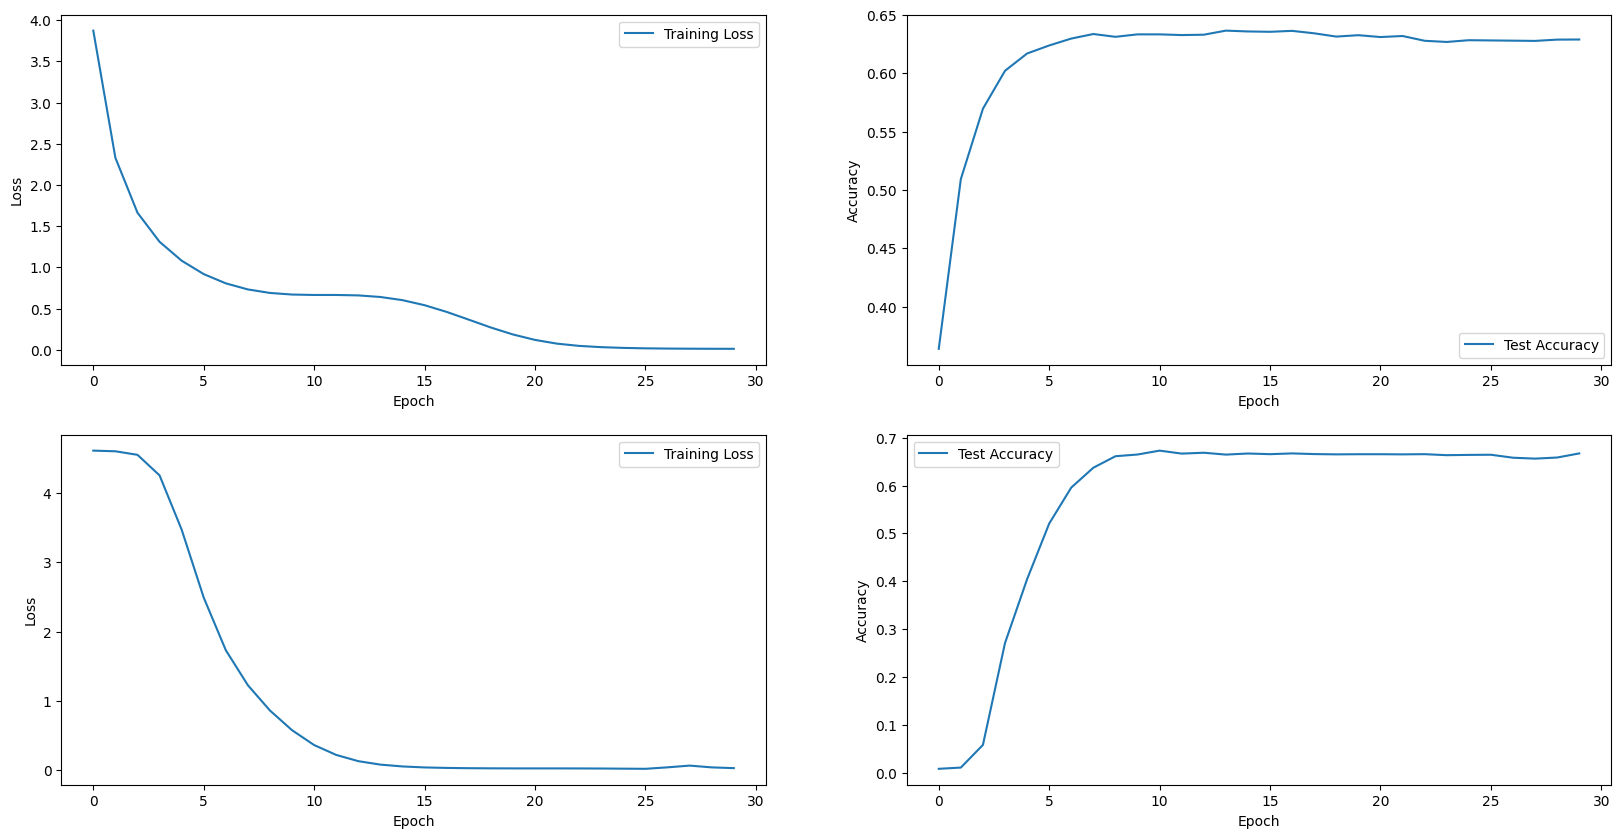

In [56]:
lossAccPlot(augmentDataModel, modelnames)

In [57]:
# Get last and max test accuracy
printTestAcc(augmentDataModel, modelnames)

ConvNeXt Tiny -> Last Test Accuracy: 0.629 | Max Test Accuracy: 0.6366 (Epoch:13)
ConvNeXt Base -> Last Test Accuracy: 0.6672 | Max Test Accuracy: 0.673 (Epoch:10)


We seem to be experiencing a drop in performance. We will try training a little longer to see whether the performance will drop further or not.

In [58]:
# Training
def continueTrain(models, modelnames, traintestData, criterion, optimizer, scheduler, num_epochs, train_loader, test_loader):

    ### Train the model ###
    for model, modelname in zip(models, modelnames):
        train_loss = traintestData[f'Training Loss_{modelname}']
        train_acc = traintestData[f'Training Accuracy_{modelname}']
        test_acc = traintestData[f'Test Accuracy_{modelname}']

        print(f'Continue Training ConvNeXt {modelname} for {num_epochs} epochs')
        print(f'Last Train Loss: {train_loss[-1]} | Last Train Accuracy: {train_acc[-1]} | Last Test Accuracy: {test_acc[-1]}')
        print('-'*20)

        for epoch in range(num_epochs):
            model.train()
            running_loss = 0.0
            total_correct = 0
            total_samples = 0
            for _, batch in enumerate(train_loader):
                images = batch[0].to(device)
                labels = batch[1].to(device).long()

                optimizer.zero_grad()
                
                outputs = model(images)

                # Convert outputs to tensor
                if isinstance(outputs, ImageClassifierOutputWithNoAttention):
                    outputs = outputs.logits

                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()

                running_loss += loss.item() * images.size(0)
                
                # Training Accuracy
                _, predicted = torch.max(outputs, dim=1)
                total_correct += (predicted == labels).sum().item()
                total_samples += labels.size(0)

            epoch_loss = running_loss/len(train_loader.dataset)
            accuracy = total_correct / total_samples

            scheduler.step()

            ### Test the model ###

            model.eval()
            num_correct = 0
            total = 0
            with torch.no_grad():
                for _, batch in enumerate(test_loader):
                    images = batch[0].to(device)
                    labels = batch[1].to(device).long()

                    outputs = model(images)

                    if isinstance(outputs, ImageClassifierOutputWithNoAttention):
                        outputs = outputs.logits
                    
                    _, predicted = torch.max(outputs, dim=1)
                    total += labels.size(0)
                    num_correct += (predicted == labels).sum().item()

            # Save the loss and accuracy for train and test set
            train_loss.append(epoch_loss)
            train_acc.append(accuracy)
            test_acc.append(num_correct/total)

            print(f'ConvNeXt {modelname} -> Epoch: {epoch+1}/{num_epochs} | Training Loss: {epoch_loss} | Training Accuracy: {accuracy} | Test Accuracy: {num_correct/total}')

        traintestData[f'Training Loss_{modelname}'] = train_loss
        traintestData[f'Training Accuracy_{modelname}'] = train_acc
        traintestData[f'Test Accuracy_{modelname}'] = test_acc

    return traintestData

In [59]:
# Continue training
augmentDataModel = continueTrain(models, modelnames, augmentDataModel, criterion, optimizer, lr_scheduler, num_epochs=20, train_loader=aug_train_loader, test_loader=aug_test_loader)

Continue Training ConvNeXt Tiny for 20 epochs
Last Train Loss: 0.012336432454288006 | Last Test Accuracy: 0.629
--------------------
ConvNeXt Tiny -> Epoch: 1/20 | Loss: 0.011839297327399254 | Test Accuracy: 0.626
ConvNeXt Tiny -> Epoch: 2/20 | Loss: 0.008313791352212429 | Test Accuracy: 0.6273
ConvNeXt Tiny -> Epoch: 3/20 | Loss: 0.00661623075261712 | Test Accuracy: 0.6273
ConvNeXt Tiny -> Epoch: 4/20 | Loss: 0.005793303342536092 | Test Accuracy: 0.6266
ConvNeXt Tiny -> Epoch: 5/20 | Loss: 0.004725187911391258 | Test Accuracy: 0.6293
ConvNeXt Tiny -> Epoch: 6/20 | Loss: 0.003785094278603792 | Test Accuracy: 0.629
ConvNeXt Tiny -> Epoch: 7/20 | Loss: 0.0031991837935894728 | Test Accuracy: 0.6278
ConvNeXt Tiny -> Epoch: 8/20 | Loss: 0.0027959965853393077 | Test Accuracy: 0.628
ConvNeXt Tiny -> Epoch: 9/20 | Loss: 0.0025862339678406716 | Test Accuracy: 0.628
ConvNeXt Tiny -> Epoch: 10/20 | Loss: 0.0024805384229123592 | Test Accuracy: 0.6285
ConvNeXt Tiny -> Epoch: 11/20 | Loss: 0.0024578

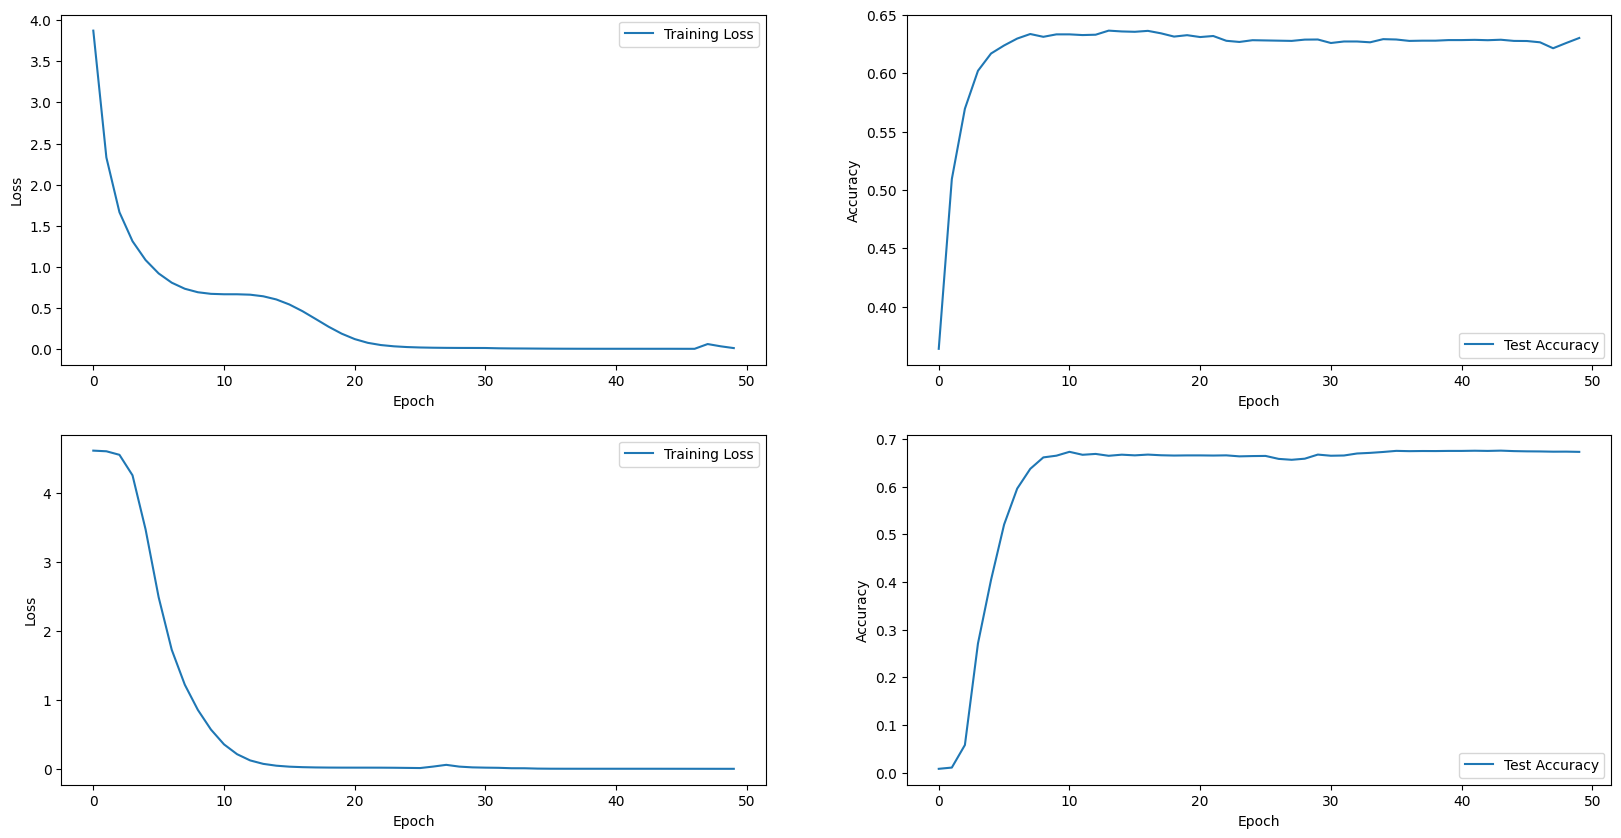

In [60]:
lossAccPlot(augmentDataModel, modelnames)

In [61]:
# Get last and max test accuracy
printTestAcc(augmentDataModel, modelnames)

ConvNeXt Tiny -> Last Test Accuracy: 0.6303 | Max Test Accuracy: 0.6366 (Epoch:13)
ConvNeXt Base -> Last Test Accuracy: 0.6729 | Max Test Accuracy: 0.6755 (Epoch:43)


We will try using the data before augmentation and data after augmentation on ConvNeXt Large to see if the model can capture more complex details from the data.

In [ ]:
del convnext_tiny, convnext_base, models, modelnames, augmentDataModel
torch.cuda.empty_cache()

In [ ]:
convnext_large = AutoModelForImageClassification.from_pretrained("facebook/convnext-large-224",
                                                        num_labels=len(label_fine),
                                                        label2id=label2id,
                                                        id2label=id2label,
                                                        ignore_mismatched_sizes=True)

convnext_large.to(device)

models = [convnext_large]
modelnames = ['LargeNoAugment']

In [ ]:
noaug_largeModel = train_model(models, modelnames, criterion, optimizer, lr_scheduler, num_epochs=30, train_loader=train_loader, test_loader=test_loader)

In [ ]:
lossAccPlot(noaug_largeModel, modelnames)

In [ ]:
printTestAcc(noaug_largeModel, modelnames)

In [ ]:
save_model(noaug_largeModel, modelnames)


del convnext_large, models, modelnames, noaug_largeModel
torch.cuda.empty_cache()

In [ ]:
convnext_large = AutoModelForImageClassification.from_pretrained("facebook/convnext-large-224",
                                                        num_labels=len(label_fine),
                                                        label2id=label2id,
                                                        id2label=id2label,
                                                        ignore_mismatched_sizes=True)

convnext_large.to(device)

models = [convnext_large]
modelnames = ['LargeAugment']

In [ ]:
aug_largeModel = train_model(models, modelnames, criterion, optimizer, lr_scheduler, num_epochs=30, train_loader=aug_train_loader, test_loader=aug_test_loader)

In [ ]:
lossAccPlot(aug_largeModel, modelnames)

In [ ]:
printTestAcc(aug_largeModel, modelnames)

In [ ]:
save_model(aug_largeModel, modelnames)

del convnext_large, models, modelnames, aug_largeModel
torch.cuda.empty_cache()